## Importing libraries

In [1]:
!pip install xgboost

In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## XGBoost implementation

### Preparing the Dataset

In [24]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_30m.csv')

In [25]:
# adding features that make more sense than raw data
all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

for lag in range(1, 4):
  all_prices[f"Gold_lag_{lag}"] = all_prices["Gold"].shift(lag)
  all_prices[f"Silver_lag_{lag}"] = all_prices["Silver"].shift(lag)
  all_prices[f"CAD_lag_{lag}"] = all_prices["CAD"].shift(lag)

In [27]:
# price to predict, the price of the next timestep
all_prices["Gold_target"] = all_prices["Gold"].shift(-1)
all_prices["Silver_target"] = all_prices["Silver"].shift(-1)
all_prices["CAD_target"] = all_prices["CAD"].shift(-1)

In [28]:
all_prices = all_prices.dropna()

In [29]:
all_prices.head()

,Datetime,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,Gold_target,Silver_target,CAD_target
4,2025-09-09 01:00:00+00:00,3726.300049,43.514999,0.724071,0.0,0.0,-0.000492,3726.300049,43.514999,0.724597,3726.300049,43.514999,0.724475
5,2025-09-09 01:30:00+00:00,3726.300049,43.514999,0.724475,0.0,0.0,0.000558,3726.300049,43.514999,0.724519,3726.300049,43.514999,0.724638
6,2025-09-09 02:00:00+00:00,3726.300049,43.514999,0.724638,0.0,0.0,0.000225,3726.300049,43.514999,0.724471,3726.300049,43.514999,0.724533
7,2025-09-09 02:30:00+00:00,3726.300049,43.514999,0.724533,0.0,0.0,-0.000145,3726.300049,43.514999,0.724429,3726.300049,43.514999,0.724255
8,2025-09-09 03:00:00+00:00,3726.300049,43.514999,0.724255,0.0,0.0,-0.000384,3726.300049,43.514999,0.724394,3726.300049,43.514999,0.724144


In [30]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2814 entries, 4 to 2817
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Datetime       2814 non-null   object 
 1   Gold           2814 non-null   float64
 2   Silver         2814 non-null   float64
 3   CAD            2814 non-null   float64
 4   Gold_ret       2814 non-null   float64
 5   Silver_ret     2814 non-null   float64
 6   CAD_ret        2814 non-null   float64
 7   Gold_ma        2814 non-null   float64
 8   Silver_ma      2814 non-null   float64
 9   CAD_ma         2814 non-null   float64
 10  Gold_target    2814 non-null   float64
 11  Silver_target  2814 non-null   float64
 12  CAD_target     2814 non-null   float64
dtypes: float64(12), object(1)
memory usage: 372.3+ KB


In [31]:
all_prices.describe()

,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,Gold_target,Silver_target,CAD_target
count,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000
mean,3996.416996,48.202537,0.715725,0.000049,0.000102,-0.000004,3996.043791,48.192896,0.715731,3996.603599,48.207357,0.715722
std,172.562411,3.021660,0.004866,0.002052,0.003403,0.000373,172.418594,3.011077,0.004866,172.554124,3.024998,0.004863
min,3721.399902,43.514999,0.707269,-0.014739,-0.039054,-0.002440,3724.160010,43.514999,0.707599,3721.399902,43.514999,0.707269
25%,3855.749939,46.641250,0.712419,-0.000601,-0.001035,-0.000201,3856.184985,46.635501,0.712408,3856.199951,46.646251,0.712419
50%,4016.650024,48.197500,0.714457,0.000000,0.000000,-0.000007,4016.100000,48.201000,0.714444,4016.750000,48.200001,0.714457
75%,4125.299805,50.568749,0.718128,0.000877,0.001458,0.000194,4126.230103,50.574750,0.718192,4125.374878,50.570000,0.718121
max,4394.299805,57.080002,0.728014,0.014620,0.045237,0.002382,4383.499902,57.080002,0.727883,4394.299805,57.080002,0.728014


In [32]:
X = all_prices.drop(columns=["Datetime", 'Gold_target', 'Silver_target', 'CAD_target'])
y = all_prices[['Gold_target', 'Silver_target', 'CAD_target']]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### XGBoost experimenting

In [34]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [35]:
num_round = 15
param = {
    'learning_rate': 0.5,
    'max_depth': 30,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-rmse:51.68176	eval-rmse:47.74140
[1]	train-rmse:26.42059	eval-rmse:25.13089
[2]	train-rmse:13.80028	eval-rmse:14.05772
[3]	train-rmse:7.63659	eval-rmse:9.94648


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[4]	train-rmse:4.46078	eval-rmse:9.06851
[5]	train-rmse:2.74583	eval-rmse:8.54510
[6]	train-rmse:1.76314	eval-rmse:8.38061
[7]	train-rmse:1.15953	eval-rmse:8.27983
[8]	train-rmse:0.78833	eval-rmse:8.24354
[9]	train-rmse:0.54756	eval-rmse:8.19715
[10]	train-rmse:0.38244	eval-rmse:8.19603
[11]	train-rmse:0.27328	eval-rmse:8.19083
[12]	train-rmse:0.19748	eval-rmse:8.19277
[13]	train-rmse:0.14385	eval-rmse:8.19995
[14]	train-rmse:0.10541	eval-rmse:8.20407


In [36]:
ypred = bst.predict(dtest)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

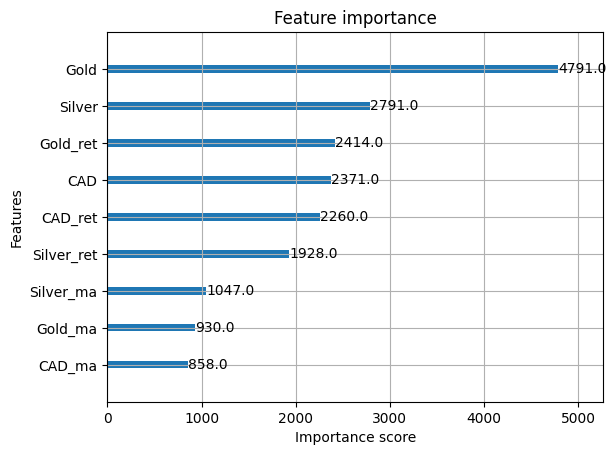

In [37]:
xgb.plot_importance(bst)

In [38]:
actual_gold  = y_test['Gold_target'].to_numpy()
actual_silver = y_test['Silver_target'].to_numpy()
actual_cad = y_test['CAD_target'].to_numpy()

In [39]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [40]:
gold_pred = ypred[:, 0]
silver_pred = ypred[:, 1]
cad_pred = ypred[:, 2]

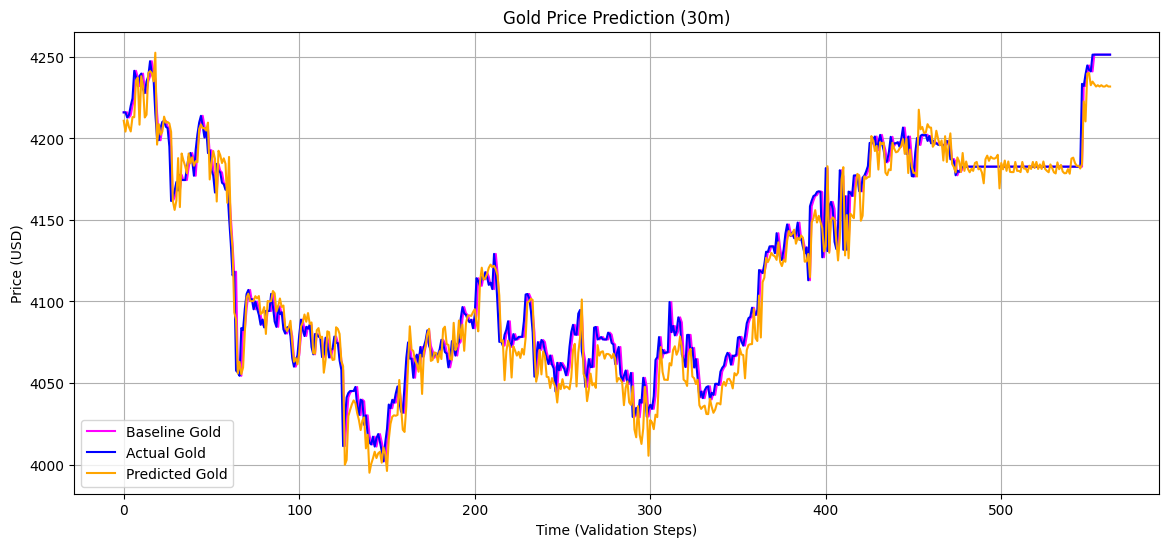

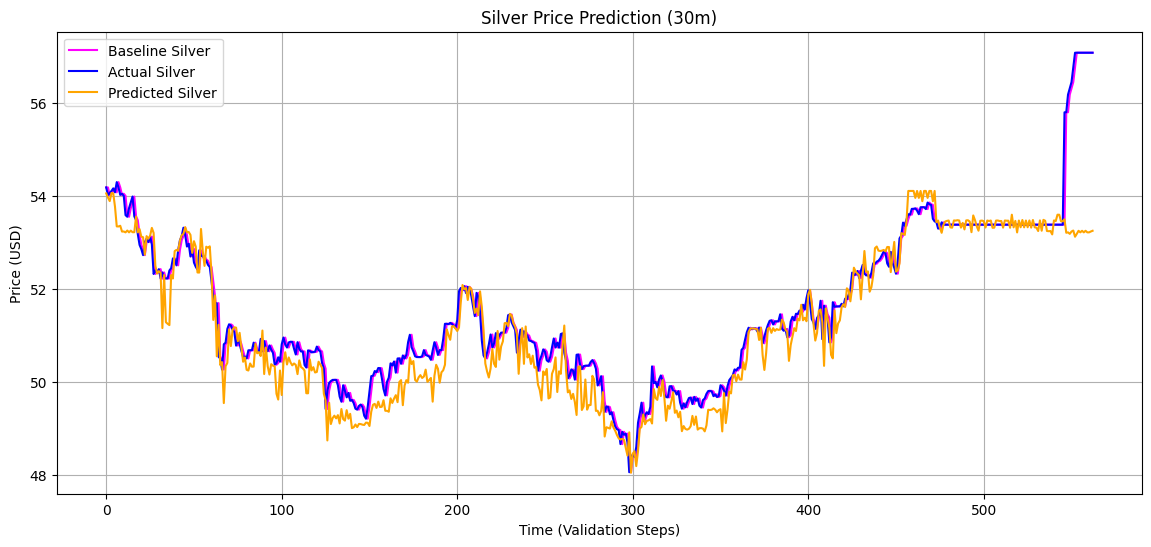

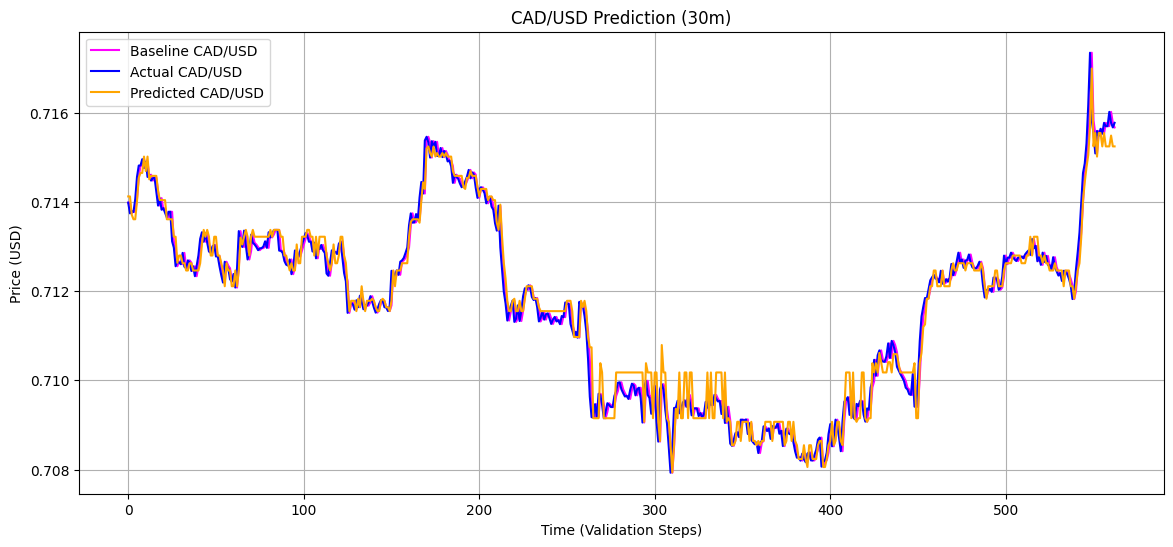

In [41]:
# gold
plt.figure(figsize=(14,6))
plt.plot(baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual_gold, color="blue", label="Actual Gold")
plt.plot(gold_pred, color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual_silver, color="blue", label="Actual Silver")
plt.plot(silver_pred, color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(cad_pred, color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Tuning